# Getting Started

This notebook demonstrates the basic functionality of `autobench`. We'll walk through the process of benchmarking `Meta-Llama-3.1-8B-Instruct` on three different GPU instances (A100, H100, & L40S) to compare performance.

In particular, we'll see how to:
1. Configure and create `Deployment`s
2. Prepare a `BenchmarkDataset`
3. Run a `Benchmark`
4. Visualize the results


## 0. Login to Hugging Face Hub

In [14]:
from huggingface_hub import interpreter_login

interpreter_login()

## 1. Deployments

First, we need a `Deployment` object to run benchmarks against.

A `Deployment` object is comprised of two main pieces:
1. `TGIConfig` - which defines the model and TGI settings for an inference endpoint
2. `ComputeInstanceConfig` - which specifies the compute instance that the model will run on


### 1.1 Getting a `TGIConfig`

A `TGIConfig` object is used to configure the details of a [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/en/index) deployment.

The primary params to configure are: 
- `model_id`: The ID of the model to deploy.
- `max_input_tokens`: The maximum input length for a query.
- `max_total_tokens`: The maximum total number of tokens for a query.
- `max_batch_prefill_tokens`: The maximum number of tokens in a prefill batch.
- `num_shard`: The number of shards to use for the deployment.



In [15]:
from autobench.config import TGIConfig

tgi_config = TGIConfig(
    model_id="meta-llama/Meta-Llama-3.1-8B-Instruct",
    max_input_tokens=8191,
    max_total_tokens=8192,
    max_batch_prefill_tokens=8242,
    num_shard=1,
)
print(tgi_config)

TGIConfig(model_id='meta-llama/Meta-Llama-3.1-8B-Instruct', max_batch_prefill_tokens=8242, max_input_tokens=8191, max_total_tokens=8192, num_shard=1, quantize=None, estimated_memory_in_gigabytes=None)


### 1.2 Getting a `ComputeInstanceConfig`

A `ComputeInstanceConfig` object encapsulates the details of a compute instance available on Hugging Face's Inference Endpoints.

We can use the `ComputeManager` class to quickly see [all available compute instance options](https://huggingface.co/docs/inference-endpoints/pricing#gpu-instances).

In [16]:
from autobench.compute_manager import ComputeManager

cm = ComputeManager()
cm.options.head(3)

,vendor,vendor_status,region,region_label,region_status,id,accelerator,num_gpus,memory_in_gb,gpu_memory_in_gb,instance_type,instance_size,architecture,status,price_per_hour,num_cpus
0,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-t4-x1,gpu,1,15,16,nvidia-t4,x1,Nvidia T4,available,0.5,3
1,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-t4-x4,gpu,4,192,64,nvidia-t4,x4,Nvidia T4,available,3.0,46
2,aws,available,us-east-1,N. Virginia,available,aws-us-east-1-nvidia-a10g-x1,gpu,1,30,24,nvidia-a10g,x1,Nvidia A10G,available,1.0,6


 Then, we can use the `from_id()` method to quickly instantiate this object. Here, we'll do so for three different instances.

In [5]:
from autobench.config import ComputeInstanceConfig

compute_config_a100 = ComputeInstanceConfig.from_id("aws-us-east-1-nvidia-a100-x1")
compute_config_h100 = ComputeInstanceConfig.from_id("gcp-us-east4-nvidia-h100-x1")
compute_config_l40s = ComputeInstanceConfig.from_id("aws-us-east-1-nvidia-l40s-x1")

print(compute_config_h100, "\n\n", compute_config_a100, "\n\n", compute_config_l40s)

ComputeInstanceConfig(id='gcp-us-east4-nvidia-h100-x1', vendor='gcp', region='us-east4', accelerator='gpu', instance_type='nvidia-h100', instance_size='x1', num_gpus=1, memory_in_gb=240, gpu_memory_in_gb=80, vendor_status='available', region_label='US East 4', region_status='available', architecture='Nvidia H100', status='available', price_per_hour=12.5, num_cpus=25) 

 ComputeInstanceConfig(id='aws-us-east-1-nvidia-a100-x1', vendor='aws', region='us-east-1', accelerator='gpu', instance_type='nvidia-a100', instance_size='x1', num_gpus=1, memory_in_gb=145, gpu_memory_in_gb=80, vendor_status='available', region_label='N. Virginia', region_status='available', architecture='Nvidia A100', status='available', price_per_hour=4.0, num_cpus=11) 

 ComputeInstanceConfig(id='aws-us-east-1-nvidia-l40s-x1', vendor='aws', region='us-east-1', accelerator='gpu', instance_type='nvidia-l40s', instance_size='x1', num_gpus=1, memory_in_gb=30, gpu_memory_in_gb=48, vendor_status='available', region_label='N

### 1.3 Creating a `Deployment`


Now we create a `Deployment` object for each of our instances with a `DeploymentConfig`.

> **Note:** we can optionally pass a `namespace` to the `DeploymentConfig` to specify an `org` to run the deployment under. By default, it will run in your user's namespace.


In [6]:
from autobench.deployment import Deployment
from autobench.config import DeploymentConfig

dcs = [
    DeploymentConfig(tgi_config=tgi_config, instance_config=compute_config_a100),
    DeploymentConfig(tgi_config=tgi_config, instance_config=compute_config_h100),
    DeploymentConfig(tgi_config=tgi_config, instance_config=compute_config_l40s),
]

deployments = [Deployment(deployment_config=dc) for dc in dcs]

We can deploy an endpoint by calling the `deploy_endpoint()` method, or leave the deployment to be created for us when running the `Benchmark` (as we'll see later on):

```python
deployment.deploy_endpoint()
```

Alternatively, we can also instantiate a `Deployment` object with an existing endpoint using the `from_existing_endpoint()` class method. This method will attempt to retrieve and start the endpoint for you.

```python
deployment = Deployment.from_existing_endpoint(
    endpoint_name="YOUR_EXISTING_ENDPOINT_NAME"
    teardown_on_exit=False,
)
```

## 2. Preparing a benchmark dataset

Along with a `Deployment`, we also need a `BenchmarkDataset` to run load tests against.

Benchmarks should be representative of the real-world usage of the deployed model. For that reason, we can configure the min/max prompt lengths to define the range of input token lengths to include in our benchmark dataset.


In [7]:
from autobench.config import DatasetConfig
from autobench.data import BenchmarkDataset

data_config = DatasetConfig(min_prompt_length=50, max_prompt_length=500)
benchmark_dataset = BenchmarkDataset(data_config)

## 3. Benchmarking

`autobench` uses [K6](https://k6.io/) to run load tests, and logically groups load tests into `ScenarioGroups`.

A  `ScenarioGroup` defines the load testing scenarios to run against a single deployment, and is comprised of:
1. a `Deployment` - the hosted Inference Endpoint to run load tests against
2. a `BenchmarkDataset` - the dataset to use for the load tests
3. a list of `Executors` - each detailing a unique load test to run


Here, we'll use a `K6ConstantArrivalRateExecutor` which simulates a constant rate of users requests arriving to the endpoint, independent of the systems response rate. This is an important distinction as it closely mimics real-world user behavior.

With each executor, we specify:
-  a `rate_per_second` parameter to define the number of requests to send per second (i.e. concurrency)
-  a `duration` parameter to define the length of time to run the load test
- a `max_new_tokens` to control the expected response length

In [8]:
from autobench.benchmark import Benchmark
from autobench.scenario import ScenarioGroup
from autobench.executor import K6ConstantArrivalRateExecutor

# define executors
executors = [
    K6ConstantArrivalRateExecutor(
        max_new_tokens=250,
        duration="30s",
        rate_per_second=arrival_rate,
        pre_allocated_vus=1000,
    )
    for arrival_rate in list(range(1, 30, 2))
]

# define scenario groups
scenario_groups = [
    ScenarioGroup(
        deployment=deployment, benchmark_dataset=benchmark_dataset, executors=executors
    )
    for deployment in deployments
]

Finally, we now use the `Benchmark` class to run the load tests for our `ScenarioGroup`s. The `Benchmark` class does the heavy lifting for us by:
- Managing our user quota to ensure compute instances are available
- Scheduling and deploying endpoints if they don't currently exist
- Running load tests and collecting results
- Saving results to disk


In [9]:
benchmark = Benchmark(
    scenarios=scenario_groups,
)
benchmark_result = benchmark.run()

2024-10-17 07:32:16 | SUCCESS  | autobench.scheduler:run:75 - Starting scheduler run
2024-10-17 07:33:24 | SUCCESS  | autobench.deployment:deploy_endpoint:210 - Endpoint created successfully: https://qwgsonlrmy83t2ym.us-east4.gcp.endpoints.huggingface.cloud
2024-10-17 07:33:24 | SUCCESS  | autobench.deployment:deploy_endpoint:210 - Endpoint created successfully: https://qdkhds2f3gg172j3.us-east-1.aws.endpoints.huggingface.cloud
2024-10-17 07:36:29 | SUCCESS  | autobench.deployment:deploy_endpoint:210 - Endpoint created successfully: https://bl1gr7ts6jh0abz0.us-east-1.aws.endpoints.huggingface.cloud
2024-10-17 07:46:42 | SUCCESS  | autobench.scheduler:deploy_and_benchmark:237 - Benchmark completed for scenerio group on instance: aws-us-east-1-nvidia-a100-x1
2024-10-17 07:46:48 | SUCCESS  | autobench.scheduler:deploy_and_benchmark:281 - Endpoint deleted for deployment: 4234b2f7-65ee-4004-bc76-732cefbd
2024-10-17 07:47:32 | SUCCESS  | autobench.scheduler:deploy_and_benchmark:237 - Benchma

We can also load a previously saved `BenchmarkResult` object if needed:

```python
from autobench.benchmark import BenchmarkResult

benchmark_result = BenchmarkResult.from_directory("path/to/benchmark_result")
```


## 4. Reporting

In [12]:
from autobench.report import gather_results, plot_results

result_df = gather_results(benchmark_result)
result_df.head()

,instance_id,instance_type,scenario_id,executor_type,pre_allocated_vus,rate,duration,test_duration,requests_ok,requests_fail,dropped_iterations,dropped_requests,error_rate,end_to_end_latency,inter_token_latency,time_to_first_token,tokens_received,tokens_throughput
0,aws-us-east-1-nvidia-a100-x1,nvidia-a100,f5ef7760-aa94-409c-b7e6-455fe40c1285,constant_arrival_rate,1000,1,30s,33.427108,31,0,0,0,0.0,3859.0,21.0,820.0,250,197.444541
1,aws-us-east-1-nvidia-a100-x1,nvidia-a100,d7f294c5-8a1a-401b-abe2-82f794a97598,constant_arrival_rate,1000,3,30s,34.042269,91,0,0,0,0.0,4338.0,32.0,680.0,250,573.463537
2,aws-us-east-1-nvidia-a100-x1,nvidia-a100,aa07bd36-51bb-4336-ba5f-afb5a92b6157,constant_arrival_rate,1000,5,30s,34.119570,150,0,0,0,0.0,5039.1,36.0,886.1,250,963.318119
3,aws-us-east-1-nvidia-a100-x1,nvidia-a100,e7f883ef-dd46-44dc-9ec6-d9e65e90f552,constant_arrival_rate,1000,7,30s,34.334407,211,0,0,0,0.0,5262.0,37.0,804.0,250,1346.025868
4,aws-us-east-1-nvidia-a100-x1,nvidia-a100,5b2e72a9-6067-4505-8c47-1de04eef48d6,constant_arrival_rate,1000,9,30s,34.649080,271,0,0,0,0.0,6088.0,41.0,929.0,250,1706.942868


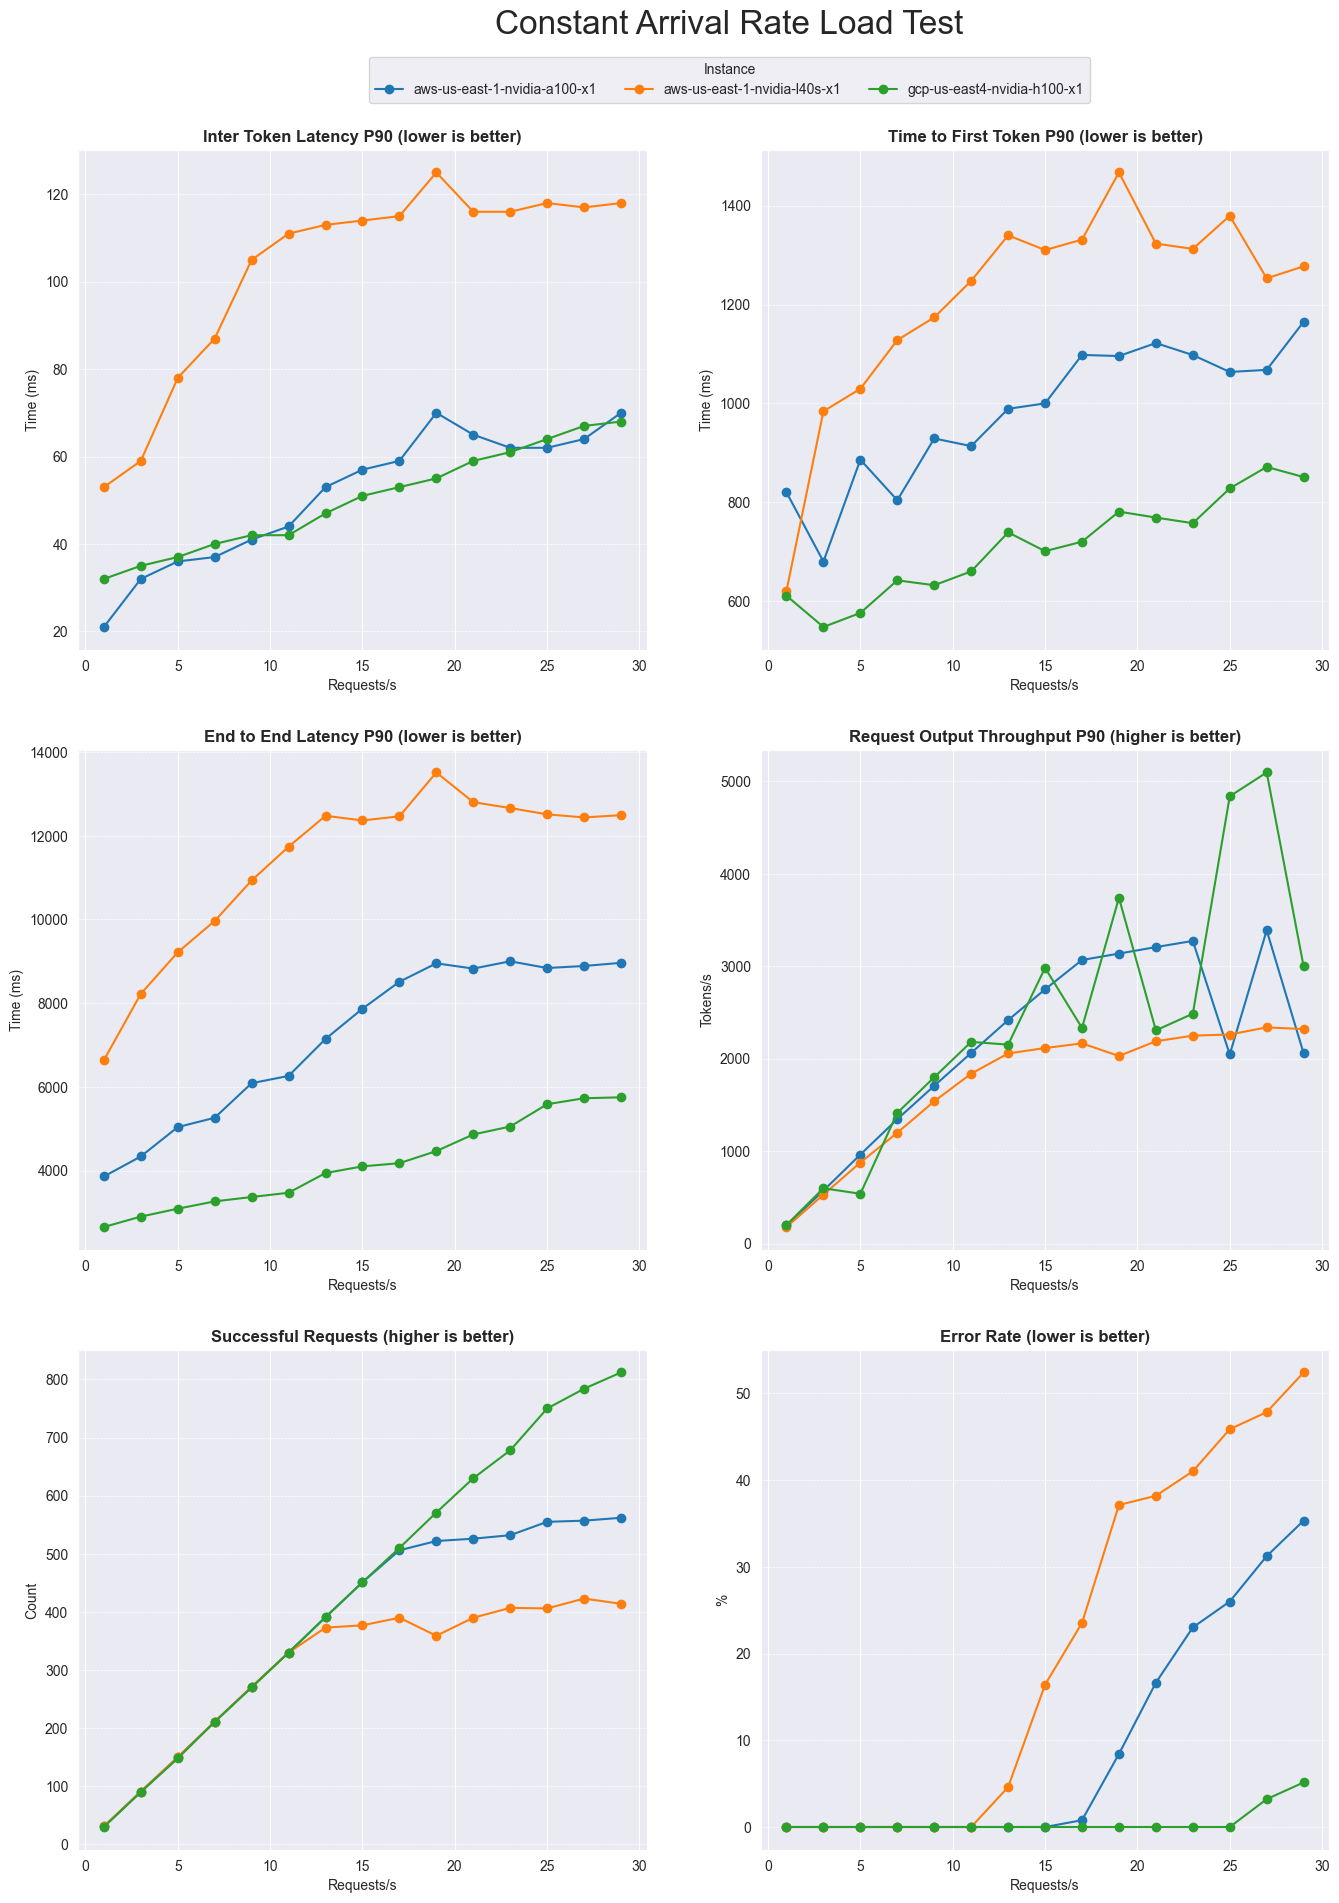

In [13]:
plot_results(result_df)